In [1]:
try:
  import google.colab
  RUNNING_ON_COLAB= True
except:
  RUNNING_ON_COLAB= False

if RUNNING_ON_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [2]:
!ls

Combine_features.ipynb			      exploration_basic.ipynb
correlations.csv			      Feature_eng.ipynb
data					      mlruns
diabetes_012_health_indicators_BRFSS2015.csv  plots
Diabetes_prediction			      SVM_model.ipynb
experimentation.ipynb


In [3]:
import os 

In [4]:
USER = os.environ.get('USER')
print(f'Current user: {USER}')

Current user: slavoj


In [5]:
PATH = 'data/diabetes_012_health_indicators_BRFSS2015.csv'

In [47]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

import lightgbm
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

import optuna
from optuna.integration import LightGBMPruningCallback

import sklearn.tree as tree
from sklearn.metrics import log_loss
import umap 

from sklearn.metrics import mean_absolute_error, mean_squared_error, matthews_corrcoef, accuracy_score, f1_score
from sklearn.metrics import classification_report


import multiprocessing
import time
import mlflow

In [7]:
data = pd.read_csv(PATH)

In [8]:
X, Y = data.drop("Diabetes_012", axis = 1), data['Diabetes_012']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 20)

In [10]:
client = mlflow.tracking.MlflowClient()

In [11]:
mlflow.tracking.get_tracking_uri()

'file:///home/slavoj/Desktop/hnnaharendt/diabetes-prediction/mlruns'

In [12]:
mlflow.sklearn.autolog()
mlflow.lightgbm.autolog()
mlflow.xgboost.autolog()

2022/01/10 00:32:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


In [20]:
def custom_logging(y_true, y_pred, verbose = 1):
    mcc = matthews_corrcoef(y_true = y_true, y_pred = y_pred)
    mse = mean_squared_error(y_true = y_true, y_pred = y_pred)
    mae = mean_absolute_error(y_true = y_true, y_pred = y_pred)
    acc = accuracy_score(y_true = y_true, y_pred = y_pred)
    f1 = f1_score(y_true = y_true, y_pred = y_pred, average='weighted')

    mlflow.log_metric(key = 'acc_', value = acc)
    mlflow.log_metric(key = 'mae_', value = mae)
    mlflow.log_metric(key = 'mse_', value = mse)
    mlflow.log_metric(key = 'f1_', value = f1)
    mlflow.log_metric(key = 'mcc_', value = mcc)

    if verbose:
        print(classification_report(y_true, y_pred, target_names=['0', '1', '2']))
        print(f"MAE: \t{mae}")
        print(f"MSE: \t{mse}")
        print(f"ACC: \t{acc}")
        print(f"MCC: \t{mcc}")

In [ ]:
mlflow.create_experiment('Tree-based methods')

#### Models w/ default params, no additional feature

In [26]:
with mlflow.start_run(run_name = "DT, default_params, no features", experiment_id = 1) as run:
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, Y_train)
    Y_preds = decision_tree.predict(X_test)
    custom_logging(Y_test, Y_preds)



2022/01/08 18:04:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.88      0.86      0.87     42753
           1       0.03      0.04      0.04       927
           2       0.30      0.32      0.31      7056

    accuracy                           0.77     50736
   macro avg       0.40      0.41      0.40     50736
weighted avg       0.78      0.77      0.77     50736

MAE: 	0.42086486912645854
MSE: 	0.801620151371807
ACC: 	0.7695127719962157
MCC: 	0.18429470140408055


In [33]:
with mlflow.start_run(run_name = "RF, default_params, no features", experiment_id = 1) as run:
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, Y_train)
    Y_preds = rf_model.predict(X_test)
    custom_logging(Y_test, Y_preds)

2022/01/08 18:48:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.02      0.00      0.00       927
           2       0.46      0.19      0.27      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.39     50736
weighted avg       0.79      0.84      0.81     50736

MAE: 	0.3010091453800063
MSE: 	0.5829391359192684
ACC: 	0.8399558498896247
MCC: 	0.22113168136271447


In [28]:
with mlflow.start_run(run_name = "XGB, default_params, no features", experiment_id = 1) as run:
    xgb_model = xgboost.XGBClassifier()
    xgb_model.fit(X_train, Y_train)
    Y_preds = xgb_model.predict(X_test)
    custom_logging(Y_test, Y_preds)

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.54      0.19      0.28      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28482734153263956
MSE: 	0.551383632923368
ACC: 	0.8484508041627247
MCC: 	0.25221772604933373


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [34]:
with mlflow.start_run(run_name = "LGBM, default_params, no features", experiment_id = 1) as run:
    lgb_model = lightgbm.LGBMClassifier()
    lgb_model.fit(X_train, Y_train)
    Y_preds = lgb_model.predict(X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.2835856196783349
MSE: 	0.5488804793440555
ACC: 	0.8490618101545254
MCC: 	0.24923258027101233


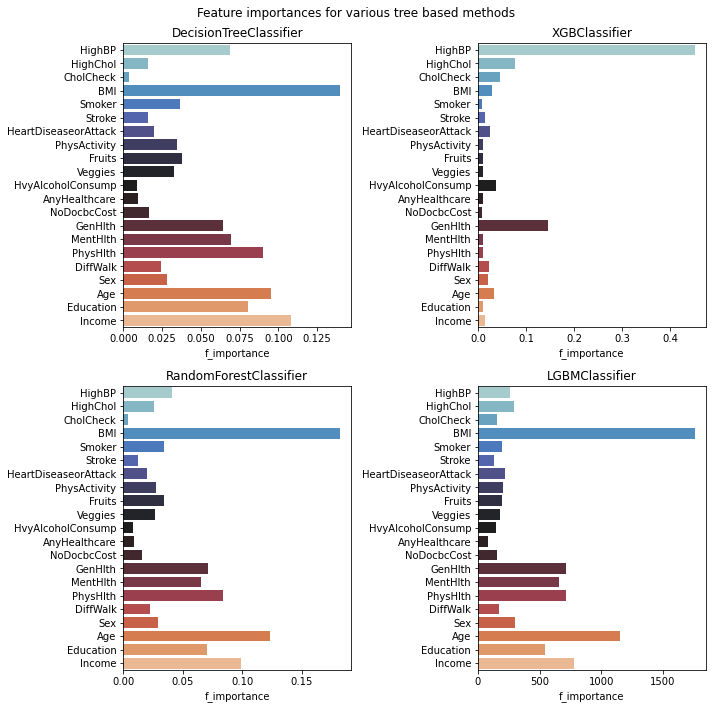

In [87]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
features = X_train.columns
i, j = 0, 0
for model in [decision_tree, rf_model, xgb_model, lgb_model]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = features,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot(y = fi_subset.index, x = fi_subset.f_importance,
    order = features, ax = axs[i][j],
    palette = 'icefire'
    ).set_title(f"{type(model).__name__}")
 
    i += 1

plt.suptitle("Feature importances for various tree based methods")   
plt.tight_layout()
plt.savefig("plots/fi_basic")
plt.show()



### Exploring dimensionality reduction 

#### PCA

In [35]:
dim_reduction = PCA(n_components = 10)
dim_reduced_X_train = dim_reduction.fit_transform(X_train)
dim_reduced_X_test = dim_reduction.transform(X_test)

2022/01/08 18:57:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3a31cf0945a84d398ed2e6dc92a6e248', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/01/08 18:57:36 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/01/08 18:57:36 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature


In [36]:

with mlflow.start_run(run_name = "DT, pca = 10", experiment_id = 1) as run:
    decision_tree_pca = DecisionTreeClassifier()
    decision_tree_pca.fit(dim_reduced_X_train, Y_train)
    Y_preds = decision_tree_pca.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

2022/01/08 19:03:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.87      0.87      0.87     42753
           1       0.02      0.03      0.03       927
           2       0.28      0.29      0.29      7056

    accuracy                           0.77     50736
   macro avg       0.39      0.39      0.39     50736
weighted avg       0.77      0.77      0.77     50736

MAE: 	0.4187756228319142
MSE: 	0.8010288552507095
ACC: 	0.7723509933774835
MCC: 	0.1658455555307739


In [37]:

with mlflow.start_run(run_name = "RF, pca = 10", experiment_id = 1) as run:
    rf_pca = RandomForestClassifier()
    rf_pca.fit(dim_reduced_X_train, Y_train)
    Y_preds = rf_pca.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

2022/01/08 19:04:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.03      0.00      0.00       927
           2       0.47      0.16      0.24      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.38      0.39     50736
weighted avg       0.79      0.84      0.80     50736

MAE: 	0.2997477136549984
MSE: 	0.5804951119520656
ACC: 	0.8406259854935352
MCC: 	0.205613877494482


In [38]:

with mlflow.start_run(run_name = "XGB, pca = 10", experiment_id = 1) as run:
    xgb_pca = xgboost.XGBClassifier()
    xgb_pca.fit(dim_reduced_X_train, Y_train)
    Y_preds = xgb_pca.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.52      0.18      0.26      7056

    accuracy                           0.85     50736
   macro avg       0.46      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.2886313465783664
MSE: 	0.5589719331441185
ACC: 	0.8465389467045096
MCC: 	0.2376376456024916


In [39]:

with mlflow.start_run(run_name = "LGBM, pca = 10", experiment_id = 1) as run:
    lgbm_pca = lightgbm.LGBMClassifier()
    lgbm_pca.fit(dim_reduced_X_train, Y_train)
    Y_preds = lgbm_pca.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.16      0.25      7056

    accuracy                           0.85     50736
   macro avg       0.46      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28809918006937874
MSE: 	0.5579273099968464
ACC: 	0.8468148848943551
MCC: 	0.23152148881331808


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

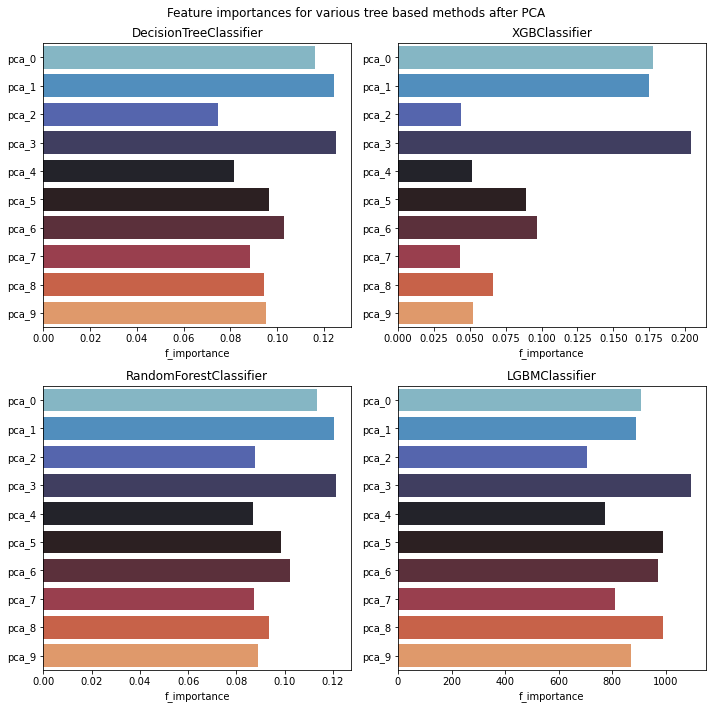

In [88]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
dim_features = pd.DataFrame(dim_reduced_X_train)
dim_features.columns = ["pca_" + str(i) for i in range(len(dim_features.columns))]

i, j = 0, 0
for model in [decision_tree_pca, rf_pca, xgb_pca, lgbm_pca]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = dim_features.columns,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot( y = fi_subset.index, x = fi_subset.f_importance,
            ax = axs[i][j],order = dim_features.columns,
            palette = 'icefire').set_title(f"{type(model).__name__}")
 
    i += 1

plt.suptitle("Feature importances for various tree based methods after PCA")   
plt.tight_layout()
plt.savefig("plots/fi_pca")
plt.show()

#### UMAP

First, in a naive way, assume that an appropriate value for the number of UMAP dimensions could be the same as for PCA.

In [18]:
dim_reduction = umap.umap_.UMAP(n_components = 10)
dim_reduced_X_train = dim_reduction.fit_transform(X_train)
dim_reduced_X_test = dim_reduction.transform(X_test)

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [19]:
with mlflow.start_run(run_name = "DT, umap = 10", experiment_id = 1) as run:
    decision_tree_umap = DecisionTreeClassifier()
    decision_tree_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = decision_tree_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)



2022/01/09 00:35:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.87      0.85      0.86     42753
           1       0.03      0.03      0.03       927
           2       0.26      0.28      0.27      7056

    accuracy                           0.76     50736
   macro avg       0.38      0.39      0.39     50736
weighted avg       0.77      0.76      0.76     50736

MAE: 	0.4460935036266162
MSE: 	0.8518014821822769
ACC: 	0.7567604856512141
MCC: 	0.13613438406695985


In [20]:
with mlflow.start_run(run_name = "RF, umap = 10", experiment_id = 1) as run:
    rf_umap = RandomForestClassifier()
    rf_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = rf_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)



2022/01/09 00:36:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.96      0.91     42753
           1       0.02      0.00      0.00       927
           2       0.39      0.14      0.21      7056

    accuracy                           0.83     50736
   macro avg       0.42      0.37      0.37     50736
weighted avg       0.78      0.83      0.79     50736

MAE: 	0.31547619047619047
MSE: 	0.6117943866288237
ACC: 	0.8326829076001262
MCC: 	0.16273817146559996


In [22]:
with mlflow.start_run(run_name = "XGB, umap = 10", experiment_id = 1) as run:
    xgb_umap = xgboost.XGBClassifier()
    xgb_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = xgb_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)



/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:41:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     42753
           1       0.00      0.00      0.00       927
           2       0.48      0.04      0.08      7056

    accuracy                           0.84     50736
   macro avg       0.44      0.35      0.33     50736
weighted avg       0.78      0.84      0.78     50736

MAE: 	0.29669268369599494
MSE: 	0.5751143172500789
ACC: 	0.842518133081047
MCC: 	0.10587732710579573


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [23]:
with mlflow.start_run(run_name = "LGBM, umap = 10", experiment_id = 1) as run:
    lgbm_umap = lightgbm.LGBMClassifier()
    lgbm_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = lgbm_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.85      1.00      0.91     42753
           1       0.00      0.00      0.00       927
           2       0.51      0.03      0.06      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.34      0.32     50736
weighted avg       0.78      0.84      0.78     50736

MAE: 	0.2953918322295806
MSE: 	0.5725126143172501
ACC: 	0.8431685588142542
MCC: 	0.09377670889739859


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

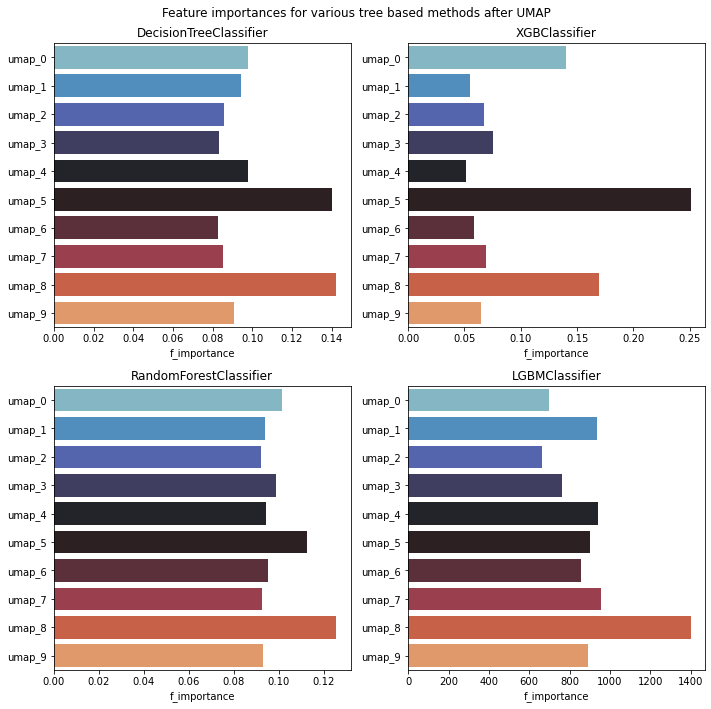

In [24]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
dim_features = pd.DataFrame(dim_reduced_X_train)
dim_features.columns = ["umap_" + str(i) for i in range(len(dim_features.columns))]

i, j = 0, 0
for model in [decision_tree_umap, rf_umap, xgb_umap, lgbm_umap]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = dim_features.columns,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot( y = fi_subset.index, x = fi_subset.f_importance,
            ax = axs[i][j],order = dim_features.columns,
            palette = 'icefire').set_title(f"{type(model).__name__}")
 
    i += 1
    
plt.suptitle("Feature importances for various tree based methods after UMAP")   
plt.tight_layout()
plt.savefig("plots/fi_umap")
plt.show()

One idea was to consider UMAP's parameters as a hyperparameter to tune in a pipeline; However, as it was not as useful in terms of model improvement or training time, this idea was dropped.

#### Binning

In [16]:
data.nunique().sort_values(ascending = False)

BMI                     84
PhysHlth                31
MentHlth                31
Age                     13
Income                   8
Education                6
GenHlth                  5
Diabetes_012             3
PhysActivity             2
Fruits                   2
Veggies                  2
HighBP                   2
AnyHealthcare            2
NoDocbcCost              2
HeartDiseaseorAttack     2
Stroke                   2
Smoker                   2
DiffWalk                 2
Sex                      2
CholCheck                2
HighChol                 2
HvyAlcoholConsump        2
dtype: int64

In [24]:
nonbinary_features = data[['BMI', 'PhysHlth', 'MentHlth', 'Age', 'Income', 'Education', 'GenHlth' ]]
nonbinary_features.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
PhysHlth,253680.0,4.242081,8.717951,0.0,0.0,0.0,3.0,30.0
MentHlth,253680.0,3.184772,7.412847,0.0,0.0,0.0,2.0,30.0
Age,253680.0,8.032119,3.054220,1.0,6.0,8.0,10.0,13.0
Income,253680.0,6.053875,2.071148,1.0,5.0,7.0,8.0,8.0
Education,253680.0,5.050434,0.985774,1.0,4.0,5.0,6.0,6.0
GenHlth,253680.0,2.511392,1.068477,1.0,2.0,2.0,3.0,5.0


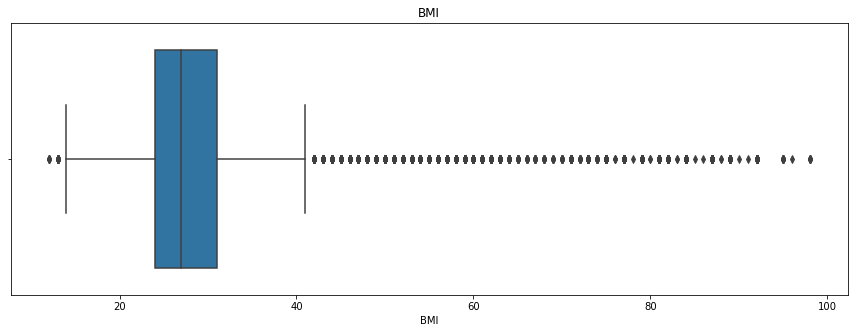

In [126]:
plt.figure(figsize=(15,5))
sns.boxplot(x = data['BMI']).set_title("BMI")
plt.show()

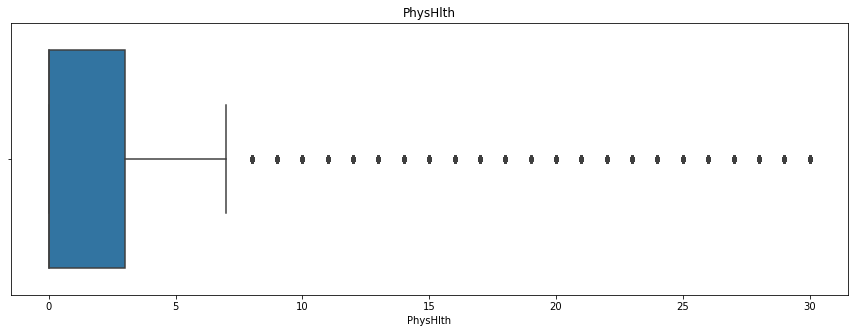

In [128]:
plt.figure(figsize=(15,5))
sns.boxplot(x = data['PhysHlth']).set_title("PhysHlth")
plt.show()

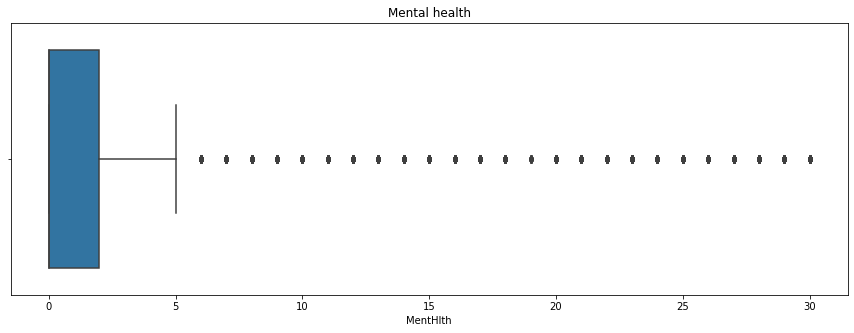

In [132]:
plt.figure(figsize=(15,5))
sns.boxplot(x = data['MentHlth'],).set_title("Mental health")
plt.show()

Use a decision tree for binning.

In [71]:
Xt = X_train[['BMI']]
Yt = Y_train

In [76]:
params = {'max_depth':[2, 3, 4, 6, 8],  'min_samples_split':[2,3,5,10]}
binning_DT = DecisionTreeClassifier()
search = GridSearchCV(binning_DT, param_grid = params, scoring = 'accuracy')
search.fit(Xt, Yt)

2022/01/09 15:13:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cce05788a4bc4336942b5e7d47c35b40', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/01/09 15:13:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 6, 8],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='accuracy')

In [77]:
search.best_params_

{'max_depth': 2, 'min_samples_split': 2}

In [78]:
binning_DT = DecisionTreeClassifier(max_depth = 2, min_samples_split = 2)
binning_DT.fit(Xt, Yt)

2022/01/09 15:13:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd0e292e7e6514c4a822b87f6f281fa91', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/01/09 15:13:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from

DecisionTreeClassifier(max_depth=2)

In [82]:
np.unique(binning_DT.predict(Xt))

array([0.])

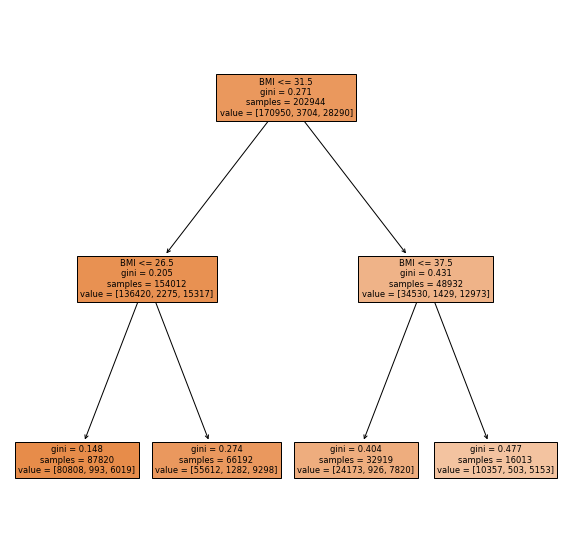

In [83]:
plt.figure(figsize= (10, 10))
tree.plot_tree(binning_DT, filled = True, feature_names = ['BMI'])
plt.show()

In [98]:
data.loc[data.BMI < 37.5]

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253674,0.0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,5.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


For age it shouldn't make that much sense as it has been already transformed from nominal to categorical, having 13 age labels.

In [84]:
Xa = X_train[['Age']]
params = {'max_depth':[2, 3, 4, 6, 8],  'min_samples_split':[2,3,5,10]}
binningAge_DT = DecisionTreeClassifier()
search = GridSearchCV(binningAge_DT, param_grid = params, scoring = 'accuracy')
search.fit(Xa, Yt)

2022/01/09 15:17:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c95f881dd27346f5ae1044789005cf24', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/01/09 15:17:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 6, 8],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='accuracy')

In [85]:
search.best_params_

{'max_depth': 2, 'min_samples_split': 2}

In [86]:
search.best_estimator_

DecisionTreeClassifier(max_depth=2)

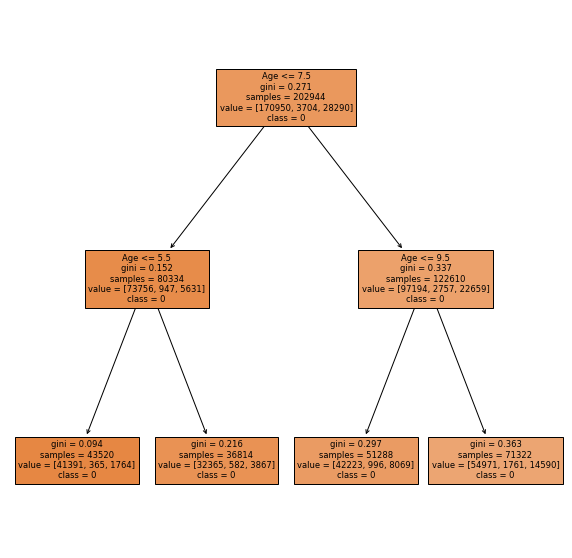

In [89]:
plt.figure(figsize= (10, 10))
tree.plot_tree(search.best_estimator_, filled = True, feature_names = ['Age'], class_names = ['0','1','2'])
plt.show()

<AxesSubplot:xlabel='Age', ylabel='Count'>

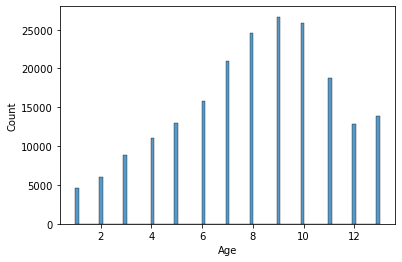

In [90]:
sns.histplot(X_train.Age)

In [108]:
X_train.Age.value_counts()

9.0     26668
10.0    25803
8.0     24620
7.0     20947
11.0    18838
6.0     15867
13.0    13884
5.0     12960
12.0    12797
4.0     11050
3.0      8900
2.0      6059
1.0      4551
Name: Age, dtype: int64

<AxesSubplot:xlabel='PhysHlth', ylabel='Count'>

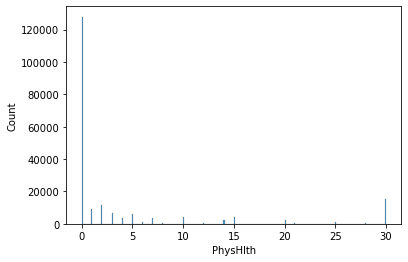

In [91]:
sns.histplot(X_train.PhysHlth)

In [92]:
Xa = X_train[['PhysHlth']]
params = {'max_depth':[2, 3, 4, 6, 8],  'min_samples_split':[2,3,5,10]}
binningAge_DT = DecisionTreeClassifier()
search = GridSearchCV(binningAge_DT, param_grid = params, scoring = 'accuracy')
search.fit(Xa, Yt)

2022/01/09 15:25:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cc946488fbfe4f929055bdbff597a70d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/01/09 15:25:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 6, 8],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='accuracy')

In [93]:
search.best_params_

{'max_depth': 2, 'min_samples_split': 2}

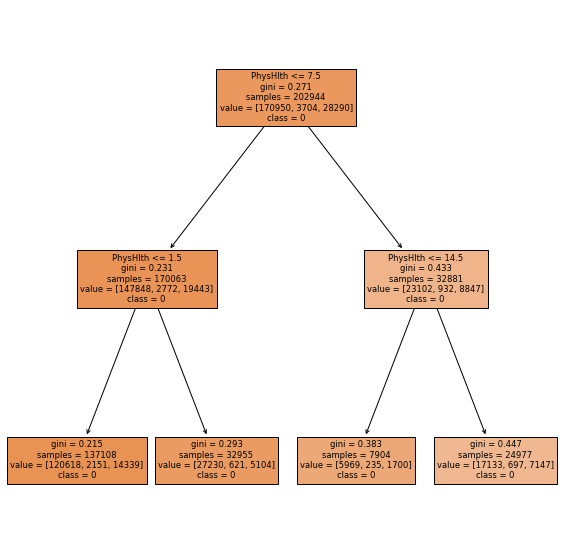

In [94]:
plt.figure(figsize= (10, 10))
tree.plot_tree(search.best_estimator_, filled = True, feature_names = ['PhysHlth'], class_names = ['0','1','2'])
plt.show()

In [112]:
data.corr()['Diabetes_012'].sort_values(ascending=False)

Diabetes_012            1.000000
GenHlth                 0.302587
HighBP                  0.271596
BMI                     0.224379
DiffWalk                0.224239
HighChol                0.209085
Age                     0.185026
HeartDiseaseorAttack    0.180272
PhysHlth                0.176287
Stroke                  0.107179
MentHlth                0.073507
CholCheck               0.067546
Smoker                  0.062914
NoDocbcCost             0.035436
Sex                     0.031040
AnyHealthcare           0.015410
Fruits                 -0.042192
HvyAlcoholConsump      -0.057882
Veggies                -0.058972
PhysActivity           -0.121947
Education              -0.130517
Income                 -0.171483
Name: Diabetes_012, dtype: float64

#### New features: Polynomial combinations

In [ ]:
['BMI^1.0 *GenHlth^1.0', 'BMI^1.0 *GenHlth^1.5',
       'HighBP^2.0 *GenHlth^1.5', 'HighBP^1.5 *GenHlth^1.5',
       'HighBP^0.5 *GenHlth^1.5', 'HighBP^2.5 *GenHlth^1.5',
       'HighBP^1.0 *GenHlth^1.5', 'HighBP^2.5 *GenHlth^2.0',
       'HighBP^2.0 *GenHlth^2.0', 'HighBP^1.5 *GenHlth^2.0',
       'HighBP^0.5 *GenHlth^2.0', 'HighBP^1.0 *GenHlth^2.0',
       'BMI^0.5 *GenHlth^0.5', 'BMI^1.0 *GenHlth^2.0']

In [24]:
new_data = data

In [25]:
new_data['BMI^1.0 *GenHlth^1.0'] = new_data['BMI'] * new_data['GenHlth']
new_data['BMI^1.0 *GenHlth^1.5'] = new_data['BMI'] * new_data['GenHlth'] ** 1.5
new_data['HighBP^2.0 *GenHlth^1.5' ] = new_data['HighBP']** 2 * new_data['GenHlth'] ** 1.5
new_data['HighBP^1.5 *GenHlth^1.5'] = new_data['HighBP'] ** 1.5 * new_data['GenHlth'] ** 1.5
new_data['HighBP^0.5 *GenHlth^1.5'] = new_data['HighBP'] ** 0.5 * new_data['GenHlth'] ** 1.5
new_data['HighBP^2.5 *GenHlth^1.5'] = new_data['HighBP'] ** 2.5 * new_data['GenHlth'] ** 1.5
new_data['HighBP^1.0 *GenHlth^1.5'] = new_data['HighBP'] ** 1 * new_data['GenHlth'] ** 1.5
new_data['HighBP^2.5 *GenHlth^2.0'] = new_data['HighBP'] ** 2.5 * new_data['GenHlth'] ** 2
new_data['HighBP^2.0 *GenHlth^2.0'] = new_data['HighBP'] ** 2 * new_data['GenHlth'] ** 2
new_data['HighBP^1.5 *GenHlth^2.0'] = new_data['HighBP'] ** 1 * new_data['GenHlth'] ** 2
new_data['HighBP^0.5 *GenHlth^2.0'] = new_data['HighBP'] ** 0.5 * new_data['GenHlth'] ** 2
new_data['HighBP^1.0 *GenHlth^2.0'] = new_data['HighBP'] ** 1 * new_data['GenHlth'] ** 2
new_data['BMI^0.5 *GenHlth^0.5'] = new_data['BMI'] ** 0.5 * new_data['GenHlth'] ** 0.5
new_data['BMI^1.0 *GenHlth^2.0'] = new_data['BMI'] ** 1 * new_data['GenHlth'] ** 2

In [26]:
new_data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,HighBP^0.5 *GenHlth^1.5,HighBP^2.5 *GenHlth^1.5,HighBP^1.0 *GenHlth^1.5,HighBP^2.5 *GenHlth^2.0,HighBP^2.0 *GenHlth^2.0,HighBP^1.5 *GenHlth^2.0,HighBP^0.5 *GenHlth^2.0,HighBP^1.0 *GenHlth^2.0,BMI^0.5 *GenHlth^0.5,BMI^1.0 *GenHlth^2.0
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,11.180340,11.180340,11.180340,25.0,25.0,25.0,25.0,25.0,14.142136,1000.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,8.660254,225.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,11.180340,11.180340,11.180340,25.0,25.0,25.0,25.0,25.0,11.832160,700.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,2.828427,2.828427,2.828427,4.0,4.0,4.0,4.0,4.0,7.348469,108.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,2.828427,2.828427,2.828427,4.0,4.0,4.0,4.0,4.0,6.928203,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,5.196152,5.196152,5.196152,9.0,9.0,9.0,9.0,9.0,11.618950,405.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,8.000000,8.000000,8.000000,16.0,16.0,16.0,16.0,16.0,8.485281,288.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,5.291503,28.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,5.196152,5.196152,5.196152,9.0,9.0,9.0,9.0,9.0,8.306624,207.0


In [20]:
X, Y = new_data.drop("Diabetes_012", axis = 1), data['Diabetes_012']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 20)

In [22]:
X_train.shape

(202944, 35)

In [27]:

with mlflow.start_run(run_name = "DT, new features >.34", experiment_id = 1) as run:
    dt_nf = DecisionTreeClassifier()
    dt_nf.fit(X_train, Y_train)
    Y_preds = dt_nf.predict(X_test)
    custom_logging(Y_test, Y_preds)

2022/01/10 01:22:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.88      0.86      0.87     42753
           1       0.03      0.03      0.03       927
           2       0.29      0.32      0.30      7056

    accuracy                           0.77     50736
   macro avg       0.40      0.40      0.40     50736
weighted avg       0.78      0.77      0.77     50736

MAE: 	0.42287527593818985
MSE: 	0.8044189530116682
ACC: 	0.7678965625985493
MCC: 	0.17970311913482


In [28]:

with mlflow.start_run(run_name = "RF, new features >.34", experiment_id = 1) as run:
    rf_nf = RandomForestClassifier()
    rf_nf.fit(X_train, Y_train)
    Y_preds = rf_nf.predict(X_test)
    custom_logging(Y_test, Y_preds)

2022/01/10 01:24:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.96      0.91     42753
           1       0.02      0.00      0.00       927
           2       0.45      0.20      0.28      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.40     50736
weighted avg       0.79      0.84      0.81     50736

MAE: 	0.3046948912015137
MSE: 	0.590212078208767
ACC: 	0.8380637023021129
MCC: 	0.22344756641302113


In [36]:

with mlflow.start_run(run_name = "XGB, new features >.34", experiment_id = 1) as run:
    xgb_nf = xgboost.XGBClassifier(objective='multi:softmax')
    xgb_nf.fit(X_train, Y_train)
    Y_preds = xgb_nf.predict(X_test)
    custom_logging(Y_test, Y_preds)

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:46:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.54      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28512298959318827
MSE: 	0.5519552191737622
ACC: 	0.8482931251970987
MCC: 	0.24724059493424325


In [29]:
xgb_nf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [35]:
with mlflow.start_run(run_name = "LGBM, new features >.34", experiment_id = 1) as run:
    lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass')
    lgbm_nf.fit(X_train, Y_train)
    Y_preds = lgbm_nf.predict(X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28344765058341215
MSE: 	0.5486242510249133
ACC: 	0.8491406496373384
MCC: 	0.2483394783185021


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [34]:
lgbm_nf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

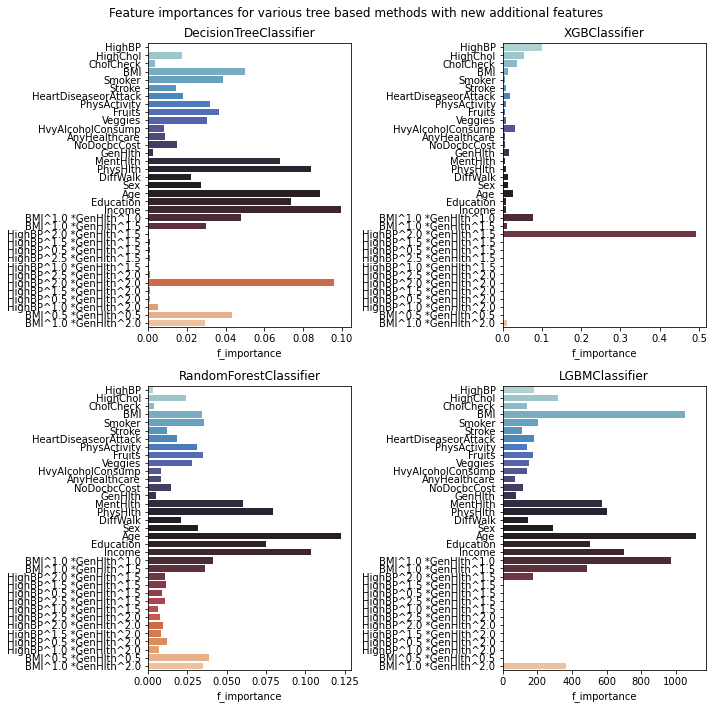

In [30]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
features = X_train.columns
i, j = 0, 0
for model in [dt_nf, rf_nf, xgb_nf, lgbm_nf]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = features,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot(y = fi_subset.index, x = fi_subset.f_importance,
    order = features, ax = axs[i][j],
    palette = 'icefire'
    ).set_title(f"{type(model).__name__}")
 
    i += 1

plt.suptitle("Feature importances for various tree based methods with new additional features")   
plt.tight_layout()
plt.savefig("plots/fi_basic")
plt.show()

#### Hyperparameter searches

In [67]:
def objective(trial, X, Y):
    param_grid = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 12000, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),

        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        )
    }

    search  = StratifiedKFold(n_splits=10, shuffle = True, random_state=20)

    scores = []

    for i, (train_i, test_i) in enumerate(search.split(X, Y)):
        X_train_, X_test_ = X.iloc[train_i], X.iloc[test_i]
        Y_train_, Y_test_ = Y.iloc[train_i], Y.iloc[test_i]

        model = lightgbm.LGBMClassifier(objective = 'multiclass', num_class = 3, **param_grid)
        model.fit(
            X_train_, Y_train_,
            eval_set = [(X_test_, Y_test_)], 
            early_stopping_rounds = 50,
            callbacks=[LightGBMPruningCallback(trial, metric = 'multi_logloss')]
        )

        Y_preds_ = model.predict(X_test_)

        acc = accuracy_score(Y_test_, Y_preds_)
        scores.append(acc)

    
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='minimize', study_name='LGBM hyperparam search 1')
func = lambda trial: objective(trial, X_train, Y_train)
study.optimize(func, n_trials=5)

In [69]:
study.best_params

{'n_estimators': 3900,
 'learning_rate': 0.27958454463927895,
 'num_leaves': 940,
 'max_depth': 10,
 'min_data_in_leaf': 5100,
 'lambda_l1': 30,
 'lambda_l2': 70,
 'min_gain_to_split': 12.049792659399,
 'bagging_fraction': 0.2,
 'bagging_freq': 1,
 'feature_fraction': 0.30000000000000004}

In [70]:
with mlflow.start_run(run_name = "LGBM, new features >.34", experiment_id = 1) as run:
    lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3, **study.best_params)
    lgbm_nf.fit(X_train, Y_train)
    Y_preds = lgbm_nf.predict(X_test)
    custom_logging(Y_test, Y_preds)

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_gain_to_split is set=12.049792659399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.049792659399
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
              precision    recall  f1-score   support

           0       0.86      0.97      0.92     42753
           1       0.00      0.00

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [74]:
modified_params = study.best_params
modified_params

{'n_estimators': 3900,
 'learning_rate': 0.27958454463927895,
 'num_leaves': 940,
 'max_depth': 10,
 'min_data_in_leaf': 5100,
 'lambda_l1': 30,
 'lambda_l2': 70,
 'min_gain_to_split': 12.049792659399,
 'bagging_fraction': 0.2,
 'bagging_freq': 1,
 'feature_fraction': 0.30000000000000004}

In [76]:
modified_params = {'n_estimators': 10000,
 'learning_rate': 0.05,
 'num_leaves': 940,
 'max_depth': 10,
 'min_data_in_leaf': 5100,
 'lambda_l1': 30,
 'lambda_l2': 70,
 'min_gain_to_split': 12.049792659399,
 'bagging_fraction': 0.2,
 'bagging_freq': 1,
 'feature_fraction': 0.3}

In [77]:
with mlflow.start_run(run_name = "LGBM, new features >.34, modified study params", experiment_id = 1) as run:
    lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3, **modified_params)
    lgbm_nf.fit(X_train, Y_train)
    Y_preds = lgbm_nf.predict(X_test)
    custom_logging(Y_test, Y_preds)

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_gain_to_split is set=12.049792659399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.049792659399
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [78]:
def objective(trial, X, Y):
    param_grid = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 12000, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),

        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        )
    }

    search  = StratifiedKFold(n_splits=5, shuffle = True, random_state=25)

    scores = []

    for i, (train_i, test_i) in enumerate(search.split(X, Y)):
        X_train_, X_test_ = X.iloc[train_i], X.iloc[test_i]
        Y_train_, Y_test_ = Y.iloc[train_i], Y.iloc[test_i]

        model = lightgbm.LGBMClassifier(objective = 'multiclass', num_class = 3, **param_grid)
        model.fit(
            X_train_, Y_train_,
            eval_set = [(X_test_, Y_test_)], 
            early_stopping_rounds = 50,
            callbacks=[LightGBMPruningCallback(trial, metric = 'multi_logloss')]
        )

        Y_preds_ = model.predict(X_test_)

        acc = accuracy_score(Y_test_, Y_preds_)
        scores.append(acc)

    
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='minimize', study_name='LGBM hyperparam search 2')
func = lambda trial: objective(trial, X_train, Y_train)
study.optimize(func, n_trials = 100)

In [80]:
study.best_params

{'n_estimators': 8100,
 'learning_rate': 0.22736659838163623,
 'num_leaves': 840,
 'max_depth': 12,
 'min_data_in_leaf': 8000,
 'lambda_l1': 10,
 'lambda_l2': 40,
 'min_gain_to_split': 7.711412911083832,
 'bagging_fraction': 0.6000000000000001,
 'bagging_freq': 1,
 'feature_fraction': 0.7}

In [81]:
with mlflow.start_run(run_name = "LGBM, new features >.34 hyperparam 2", experiment_id = 1) as run:
    lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3, **study.best_params)
    lgbm_nf.fit(X_train, Y_train)
    Y_preds = lgbm_nf.predict(X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.54      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.39     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28604935351624095
MSE: 	0.5538276568905708
ACC: 	0.847839798170924
MCC: 	0.24433181642217056


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
study.optimize(func, n_trials = 2000)

In [86]:
study.best_params

{'n_estimators': 8100,
 'learning_rate': 0.22736659838163623,
 'num_leaves': 840,
 'max_depth': 12,
 'min_data_in_leaf': 8000,
 'lambda_l1': 10,
 'lambda_l2': 40,
 'min_gain_to_split': 7.711412911083832,
 'bagging_fraction': 0.6000000000000001,
 'bagging_freq': 1,
 'feature_fraction': 0.7}

In [84]:
with mlflow.start_run(run_name = "LGBM, new features >.34 hyperparam 3", experiment_id = 1) as run:
    lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3, **study.best_params)
    lgbm_nf.fit(X_train, Y_train)
    Y_preds = lgbm_nf.predict(X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.54      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.39     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28604935351624095
MSE: 	0.5538276568905708
ACC: 	0.847839798170924
MCC: 	0.24433181642217056


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [85]:
lgbm_nf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.22736659838163623,
 'max_depth': 12,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 8100,
 'n_jobs': -1,
 'num_leaves': 840,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'num_classes': 3,
 'min_data_in_leaf': 8000,
 'lambda_l1': 10,
 'lambda_l2': 40,
 'min_gain_to_split': 7.711412911083832,
 'bagging_fraction': 0.6000000000000001,
 'bagging_freq': 1,
 'feature_fraction': 0.7}

In [107]:
def objective(trial, X, Y, cv, scoring):
    param_grid = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 12000, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),

        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        )
    }

    model = lightgbm.LGBMClassifier(objective = 'multiclass', num_class = 3, **param_grid)
    scores = cross_validate(model, X, Y, cv = cv, scoring = scoring, n_jobs = -1)

    return np.mean(scores['test_score'])

#### LGBM study; search w/ optuna

In [108]:
study = optuna.create_study(direction='maximize', study_name='LGBM hyperparam search 3')

stk = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
func = lambda trial: objective(trial, X_train, Y_train, stk, 'accuracy' )
study.optimize(func, n_trials = 100)

[I 2022-01-10 13:40:12,796] A new study created in memory with name: LGBM hyperparam search 3
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4

[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_gain_to_split is set=5.394111862304197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.394111862304197
[LightGBM] [Warning] min_gain_to_split is set=5.394111862304197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.394111862304197[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

[I 2022-01-10 13:45:27,364] Trial 0 finished with value: 0.8485296432666223 and parameters: {'n_estimators': 11500, 'learning_rate': 0.12438797551100772, 'num_leaves': 2640, 'max_depth': 9, 'min_data_in_leaf': 7500, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 5.394111862304197, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.8485296432666223.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] min_gain_to_split is set=4.979738919733999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.979738919733999
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value:

[I 2022-01-10 13:46:01,472] Trial 1 finished with value: 0.848776014950816 and parameters: {'n_estimators': 900, 'learning_rate': 0.25446419446470175, 'num_leaves': 600, 'max_depth': 13, 'min_data_in_leaf': 6300, 'lambda_l1': 45, 'lambda_l2': 10, 'min_gain_to_split': 4.979738919733999, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.848776014950816.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55

[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55[LightGBM] [Warning] min_gain_to_split is set=9.695275310716157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.695275310716157

[LightGBM] [Warning] min_gain_to_split is set=9.695275310716157, min_split_gain=0.0 will be ignore

[I 2022-01-10 13:47:21,727] Trial 2 finished with value: 0.8483670345995173 and parameters: {'n_estimators': 3500, 'learning_rate': 0.14495220669170197, 'num_leaves': 1500, 'max_depth': 14, 'min_data_in_leaf': 4800, 'lambda_l1': 55, 'lambda_l2': 65, 'min_gain_to_split': 9.695275310716157, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.848776014950816.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45


[LightGBM] [Warning] min_gain_to_split is set=14.712112494554658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.712112494554658[LightGBM] [Warning] min_gain_to_split is set=14.712112494554658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.712112494554658

[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-01-10 13:50:36,266] Trial 3 finished with value: 0.8490519543304227 and parameters: {'n_estimators': 8500, 'learning_rate': 0.18766678171166898, 'num_leaves': 1200, 'max_depth': 9, 'min_data_in_leaf': 1900, 'lambda_l1': 45, 'lambda_l2': 85, 'min_gain_to_split': 14.712112494554658, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 3 with value: 0.8490519543304227.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] min_gain_to_split is set=7.995584233600513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.995584233600513
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0

[I 2022-01-10 13:52:32,572] Trial 4 finished with value: 0.8481157337723069 and parameters: {'n_estimators': 6900, 'learning_rate': 0.15842263171021725, 'num_leaves': 2980, 'max_depth': 12, 'min_data_in_leaf': 4300, 'lambda_l1': 65, 'lambda_l2': 80, 'min_gain_to_split': 7.995584233600513, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.8490519543304227.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=10.802302671737582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.802302671737582
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] la

[I 2022-01-10 13:55:57,078] Trial 5 finished with value: 0.8493968760965513 and parameters: {'n_estimators': 8500, 'learning_rate': 0.01552046578738879, 'num_leaves': 1520, 'max_depth': 15, 'min_data_in_leaf': 2100, 'lambda_l1': 20, 'lambda_l2': 5, 'min_gain_to_split': 10.802302671737582, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 5 with value: 0.8493968760965513.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] min_gain_to_split is set=0.5298757111723168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5298757111723168
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=90, reg_alp

[I 2022-01-10 13:56:47,803] Trial 6 finished with value: 0.8483916740017241 and parameters: {'n_estimators': 1900, 'learning_rate': 0.13551750725479342, 'num_leaves': 160, 'max_depth': 13, 'min_data_in_leaf': 10000, 'lambda_l1': 90, 'lambda_l2': 85, 'min_gain_to_split': 0.5298757111723168, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 5 with value: 0.8493968760965513.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=11.439104028574475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.439104028574475
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60000000

[I 2022-01-10 13:59:24,109] Trial 7 finished with value: 0.8485887725873742 and parameters: {'n_estimators': 5100, 'learning_rate': 0.15910966045325856, 'num_leaves': 1980, 'max_depth': 3, 'min_data_in_leaf': 8500, 'lambda_l1': 10, 'lambda_l2': 90, 'min_gain_to_split': 11.439104028574475, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 5 with value: 0.8493968760965513.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_gain_to_split is set=10.238226996565258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.238226996565258
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0

[I 2022-01-10 14:03:16,358] Trial 8 finished with value: 0.8493377479898143 and parameters: {'n_estimators': 8500, 'learning_rate': 0.08305291539471599, 'num_leaves': 2700, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 60, 'lambda_l2': 85, 'min_gain_to_split': 10.238226996565258, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 5 with value: 0.8493968760965513.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] min_gain_to_split is set=1.2795147497822479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2795147497822479
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0

[I 2022-01-10 14:05:35,571] Trial 9 finished with value: 0.8488499269659604 and parameters: {'n_estimators': 8700, 'learning_rate': 0.1904188645468667, 'num_leaves': 2360, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 75, 'lambda_l2': 40, 'min_gain_to_split': 1.2795147497822479, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 5 with value: 0.8493968760965513.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=14.456119295039045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.456119295039045
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 

[I 2022-01-10 14:09:19,260] Trial 10 finished with value: 0.8494658620037161 and parameters: {'n_estimators': 11500, 'learning_rate': 0.007385383754433315, 'num_leaves': 1080, 'max_depth': 7, 'min_data_in_leaf': 3000, 'lambda_l1': 0, 'lambda_l2': 0, 'min_gain_to_split': 14.456119295039045, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.8494658620037161.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=14.965478581146243, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.965478581146243
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 

[I 2022-01-10 14:13:07,332] Trial 11 finished with value: 0.8494313698999439 and parameters: {'n_estimators': 11500, 'learning_rate': 0.005504327756705733, 'num_leaves': 860, 'max_depth': 6, 'min_data_in_leaf': 2900, 'lambda_l1': 0, 'lambda_l2': 0, 'min_gain_to_split': 14.965478581146243, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.8494658620037161.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=14.805788198376382, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.805788198376382
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] bagging_fraction is set=0.8, subs

[I 2022-01-10 14:17:15,735] Trial 12 finished with value: 0.8494313688073307 and parameters: {'n_estimators': 11700, 'learning_rate': 0.006508141264806172, 'num_leaves': 940, 'max_depth': 6, 'min_data_in_leaf': 3600, 'lambda_l1': 0, 'lambda_l2': 25, 'min_gain_to_split': 14.805788198376382, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.8494658620037161.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_gain_to_split is set=13.07544242093916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.07544242093916
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0

[I 2022-01-10 14:20:37,042] Trial 13 finished with value: 0.8491948504317095 and parameters: {'n_estimators': 10700, 'learning_rate': 0.05886220159613527, 'num_leaves': 540, 'max_depth': 6, 'min_data_in_leaf': 2900, 'lambda_l1': 30, 'lambda_l2': 20, 'min_gain_to_split': 13.07544242093916, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.8494658620037161.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=12.780818260168719, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.780818260168719
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.

[I 2022-01-10 14:24:31,720] Trial 14 finished with value: 0.8486971773132981 and parameters: {'n_estimators': 10100, 'learning_rate': 0.053799164501499006, 'num_leaves': 880, 'max_depth': 6, 'min_data_in_leaf': 5800, 'lambda_l1': 0, 'lambda_l2': 30, 'min_gain_to_split': 12.780818260168719, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 10 with value: 0.8494658620037161.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=13.138299080910825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.138299080910825
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0

[I 2022-01-10 14:26:51,237] Trial 15 finished with value: 0.849249052916073 and parameters: {'n_estimators': 6700, 'learning_rate': 0.08771073658490926, 'num_leaves': 40, 'max_depth': 7, 'min_data_in_leaf': 1900, 'lambda_l1': 10, 'lambda_l2': 0, 'min_gain_to_split': 13.138299080910825, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 10 with value: 0.8494658620037161.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_gain_to_split is set=7.057708047367583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.057708047367583
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7[LightGBM] [Warning] bagging_fraction is set=0.7, subs

[I 2022-01-10 14:30:07,221] Trial 16 finished with value: 0.849219487041682 and parameters: {'n_estimators': 10500, 'learning_rate': 0.03515104131362289, 'num_leaves': 1640, 'max_depth': 8, 'min_data_in_leaf': 3200, 'lambda_l1': 35, 'lambda_l2': 60, 'min_gain_to_split': 7.057708047367583, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.8494658620037161.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=14.90618517441428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.90618517441428
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0

[I 2022-01-10 14:32:08,595] Trial 17 finished with value: 0.8487710883572305 and parameters: {'n_estimators': 5300, 'learning_rate': 0.29253258697752677, 'num_leaves': 1120, 'max_depth': 4, 'min_data_in_leaf': 4100, 'lambda_l1': 10, 'lambda_l2': 10, 'min_gain_to_split': 14.90618517441428, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 10 with value: 0.8494658620037161.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=2.695255981518919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.695255981518919
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0

[I 2022-01-10 14:39:34,903] Trial 18 finished with value: 0.8497073097651568 and parameters: {'n_estimators': 9700, 'learning_rate': 0.10158954467703958, 'num_leaves': 540, 'max_depth': 5, 'min_data_in_leaf': 1200, 'lambda_l1': 15, 'lambda_l2': 15, 'min_gain_to_split': 2.695255981518919, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] min_gain_to_split is set=2.6242505019118485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6242505019118485
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=100, reg_al

[I 2022-01-10 14:47:38,336] Trial 19 finished with value: 0.8493328210320243 and parameters: {'n_estimators': 10300, 'learning_rate': 0.10246840612112068, 'num_leaves': 360, 'max_depth': 4, 'min_data_in_leaf': 1300, 'lambda_l1': 100, 'lambda_l2': 20, 'min_gain_to_split': 2.6242505019118485, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=3.4031903173578177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4031903173578177
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0

[I 2022-01-10 14:55:13,693] Trial 20 finished with value: 0.8496186155412259 and parameters: {'n_estimators': 9500, 'learning_rate': 0.22436352203394483, 'num_leaves': 1880, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 3.4031903173578177, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=3.5833506163581657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5833506163581657
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha

[I 2022-01-10 15:02:58,882] Trial 21 finished with value: 0.8494510800377325 and parameters: {'n_estimators': 9700, 'learning_rate': 0.22926257640674302, 'num_leaves': 1840, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 3.5833506163581657, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_gain_to_split is set=2.4479707855260706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4479707855260706
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha

[I 2022-01-10 15:08:38,697] Trial 22 finished with value: 0.8494264443989717 and parameters: {'n_estimators': 7100, 'learning_rate': 0.21820144259648863, 'num_leaves': 1960, 'max_depth': 10, 'min_data_in_leaf': 2200, 'lambda_l1': 35, 'lambda_l2': 15, 'min_gain_to_split': 2.4479707855260706, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=4.476577664428338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.476577664428338
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] 

[I 2022-01-10 15:15:48,638] Trial 23 finished with value: 0.849515137166085 and parameters: {'n_estimators': 9500, 'learning_rate': 0.2665014859475309, 'num_leaves': 1280, 'max_depth': 11, 'min_data_in_leaf': 1200, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 4.476577664428338, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=4.649823204602128, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.649823204602128
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] la

[I 2022-01-10 15:21:41,981] Trial 24 finished with value: 0.8495052813080811 and parameters: {'n_estimators': 7700, 'learning_rate': 0.29751658777985057, 'num_leaves': 2340, 'max_depth': 11, 'min_data_in_leaf': 300, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 4.649823204602128, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_gain_to_split is set=6.825929223225852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.825929223225852
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] 

[I 2022-01-10 15:28:33,795] Trial 25 finished with value: 0.8496678887611709 and parameters: {'n_estimators': 9100, 'learning_rate': 0.26674975567368975, 'num_leaves': 1280, 'max_depth': 11, 'min_data_in_leaf': 1100, 'lambda_l1': 40, 'lambda_l2': 55, 'min_gain_to_split': 6.825929223225852, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_gain_to_split is set=6.498954956670174, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.498954956670174
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0

[I 2022-01-10 15:35:57,059] Trial 26 finished with value: 0.8490371722430379 and parameters: {'n_estimators': 9300, 'learning_rate': 0.24932828360687415, 'num_leaves': 2180, 'max_depth': 10, 'min_data_in_leaf': 1100, 'lambda_l1': 40, 'lambda_l2': 55, 'min_gain_to_split': 6.498954956670174, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_gain_to_split is set=2.1008276758705673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1008276758705673
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha

[I 2022-01-10 15:42:00,597] Trial 27 finished with value: 0.8495496295126597 and parameters: {'n_estimators': 7500, 'learning_rate': 0.1913772141604515, 'num_leaves': 1740, 'max_depth': 11, 'min_data_in_leaf': 2300, 'lambda_l1': 30, 'lambda_l2': 70, 'min_gain_to_split': 2.1008276758705673, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_gain_to_split is set=8.357463356577203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.357463356577203
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] 

[I 2022-01-10 15:45:55,131] Trial 28 finished with value: 0.8494412241797287 and parameters: {'n_estimators': 5300, 'learning_rate': 0.21589065541824956, 'num_leaves': 600, 'max_depth': 8, 'min_data_in_leaf': 1500, 'lambda_l1': 50, 'lambda_l2': 50, 'min_gain_to_split': 8.357463356577203, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_gain_to_split is set=6.026071429695647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.026071429695647
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60000000

[I 2022-01-10 15:47:32,995] Trial 29 finished with value: 0.8490125342976489 and parameters: {'n_estimators': 3700, 'learning_rate': 0.11404621803335199, 'num_leaves': 1340, 'max_depth': 10, 'min_data_in_leaf': 6300, 'lambda_l1': 25, 'lambda_l2': 100, 'min_gain_to_split': 6.026071429695647, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_gain_to_split is set=3.0179526476882406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0179526476882406
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0

[I 2022-01-10 15:56:24,088] Trial 30 finished with value: 0.8494560110017716 and parameters: {'n_estimators': 10900, 'learning_rate': 0.2625582709842337, 'num_leaves': 360, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 3.0179526476882406, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_gain_to_split is set=1.5342793967314483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5342793967314483
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha

[I 2022-01-10 16:03:01,743] Trial 31 finished with value: 0.849396878767384 and parameters: {'n_estimators': 8100, 'learning_rate': 0.1865619198818937, 'num_leaves': 1700, 'max_depth': 11, 'min_data_in_leaf': 2600, 'lambda_l1': 30, 'lambda_l2': 70, 'min_gain_to_split': 1.5342793967314483, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_gain_to_split is set=3.808161923490151, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.808161923490151
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0

[I 2022-01-10 16:09:22,307] Trial 32 finished with value: 0.8494806431198892 and parameters: {'n_estimators': 7500, 'learning_rate': 0.23362839903975563, 'num_leaves': 2140, 'max_depth': 12, 'min_data_in_leaf': 1800, 'lambda_l1': 40, 'lambda_l2': 75, 'min_gain_to_split': 3.808161923490151, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_gain_to_split is set=5.4754835861020785, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.4754835861020785
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] 

[I 2022-01-10 16:14:17,643] Trial 33 finished with value: 0.8495102075374621 and parameters: {'n_estimators': 6100, 'learning_rate': 0.20126069803961028, 'num_leaves': 1480, 'max_depth': 13, 'min_data_in_leaf': 200, 'lambda_l1': 30, 'lambda_l2': 60, 'min_gain_to_split': 5.4754835861020785, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_gain_to_split is set=1.9351859462916963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9351859462916963
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha

[I 2022-01-10 16:21:38,880] Trial 34 finished with value: 0.8492539810878779 and parameters: {'n_estimators': 9100, 'learning_rate': 0.17297105768690205, 'num_leaves': 1760, 'max_depth': 10, 'min_data_in_leaf': 2400, 'lambda_l1': 50, 'lambda_l2': 65, 'min_gain_to_split': 1.9351859462916963, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 18 with value: 0.8497073097651568.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=0.17517163429361648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.17517163429361648
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warni

[I 2022-01-10 16:26:49,066] Trial 35 finished with value: 0.8499044049515654 and parameters: {'n_estimators': 6300, 'learning_rate': 0.275555377281961, 'num_leaves': 1400, 'max_depth': 9, 'min_data_in_leaf': 3800, 'lambda_l1': 20, 'lambda_l2': 50, 'min_gain_to_split': 0.17517163429361648, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=0.583999879686731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.583999879686731
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] 

[I 2022-01-10 16:26:56,038] Trial 36 finished with value: 0.8496136843343839 and parameters: {'n_estimators': 100, 'learning_rate': 0.27951171090437943, 'num_leaves': 740, 'max_depth': 9, 'min_data_in_leaf': 5100, 'lambda_l1': 20, 'lambda_l2': 50, 'min_gain_to_split': 0.583999879686731, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9

[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70

[LightGBM] [Warning] min_gain_to_split is set=0.09347960195053309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09347960195053309
[LightGBM] [Warning] min_gain_to_split is set=0.09347960195053309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09347960195053309
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70[LightGBM] [Warning] min_data_in_le

[I 2022-01-10 16:29:01,383] Trial 37 finished with value: 0.8493919502313746 and parameters: {'n_estimators': 4500, 'learning_rate': 0.24434602997894786, 'num_leaves': 1400, 'max_depth': 14, 'min_data_in_leaf': 3800, 'lambda_l1': 70, 'lambda_l2': 45, 'min_gain_to_split': 0.09347960195053309, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15

[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15[LightGBM] [Warning] min_gain_to_split is set=9.337642578770538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.337642578770538

[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=9.337642578770538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.337642578770538
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, cols

[I 2022-01-10 16:29:52,352] Trial 38 finished with value: 0.8485838449011753 and parameters: {'n_estimators': 2100, 'learning_rate': 0.2731994031288689, 'num_leaves': 1560, 'max_depth': 4, 'min_data_in_leaf': 4600, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 9.337642578770538, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=3.5881536491408204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5881536491408204
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] 

[I 2022-01-10 16:32:55,937] Trial 39 finished with value: 0.8490716639826053 and parameters: {'n_estimators': 6300, 'learning_rate': 0.2864679910934334, 'num_leaves': 1180, 'max_depth': 5, 'min_data_in_leaf': 7400, 'lambda_l1': 5, 'lambda_l2': 55, 'min_gain_to_split': 3.5881536491408204, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] min_gain_to_split is set=1.0238769835255301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0238769835255301
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0

[I 2022-01-10 16:37:00,201] Trial 40 finished with value: 0.8493722403363891 and parameters: {'n_estimators': 8900, 'learning_rate': 0.25086182600873785, 'num_leaves': 2780, 'max_depth': 13, 'min_data_in_leaf': 800, 'lambda_l1': 45, 'lambda_l2': 10, 'min_gain_to_split': 1.0238769835255301, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=0.5852083240019976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5852083240019976
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha

[I 2022-01-10 16:38:15,756] Trial 41 finished with value: 0.8497171640449412 and parameters: {'n_estimators': 1500, 'learning_rate': 0.2779684763085472, 'num_leaves': 700, 'max_depth': 9, 'min_data_in_leaf': 5300, 'lambda_l1': 20, 'lambda_l2': 50, 'min_gain_to_split': 0.5852083240019976, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_gain_to_split is set=0.08634769192398133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08634769192398133
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=25, reg_alp

[I 2022-01-10 16:40:11,020] Trial 42 finished with value: 0.8498157114560433 and parameters: {'n_estimators': 2100, 'learning_rate': 0.26599258894608574, 'num_leaves': 420, 'max_depth': 9, 'min_data_in_leaf': 5600, 'lambda_l1': 25, 'lambda_l2': 55, 'min_gain_to_split': 0.08634769192398133, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_gain_to_split is set=0.22775955665539832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22775955665539832
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=40, reg_alp

[I 2022-01-10 16:41:59,524] Trial 43 finished with value: 0.849643251058585 and parameters: {'n_estimators': 2100, 'learning_rate': 0.13932583616797048, 'num_leaves': 280, 'max_depth': 9, 'min_data_in_leaf': 5900, 'lambda_l1': 40, 'lambda_l2': 55, 'min_gain_to_split': 0.22775955665539832, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_gain_to_split is set=1.1072331053348754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1072331053348754
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current valu

[I 2022-01-10 16:42:44,466] Trial 44 finished with value: 0.8494855760263519 and parameters: {'n_estimators': 1300, 'learning_rate': 0.29994763507072747, 'num_leaves': 620, 'max_depth': 7, 'min_data_in_leaf': 7100, 'lambda_l1': 25, 'lambda_l2': 60, 'min_gain_to_split': 1.1072331053348754, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5


[LightGBM] [Warning] min_gain_to_split is set=1.5652552034942908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5652552034942908[LightGBM] [Warning] min_gain_to_split is set=1.5652552034942908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5652552034942908
[LightGBM] [Warning] min_gain_to_split is set

[I 2022-01-10 16:44:12,580] Trial 45 finished with value: 0.8493623845997866 and parameters: {'n_estimators': 2700, 'learning_rate': 0.2772687298883271, 'num_leaves': 1000, 'max_depth': 8, 'min_data_in_leaf': 5600, 'lambda_l1': 5, 'lambda_l2': 45, 'min_gain_to_split': 1.5652552034942908, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_gain_to_split is set=0.6827476806445129, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6827476806445129
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning

[I 2022-01-10 16:46:36,772] Trial 46 finished with value: 0.8493032566144512 and parameters: {'n_estimators': 3300, 'learning_rate': 0.26080661884547723, 'num_leaves': 460, 'max_depth': 12, 'min_data_in_leaf': 6500, 'lambda_l1': 35, 'lambda_l2': 65, 'min_gain_to_split': 0.6827476806445129, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=0.2520880426323188, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2520880426323188
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha

[I 2022-01-10 16:46:41,199] Trial 47 finished with value: 0.8493180370022154 and parameters: {'n_estimators': 100, 'learning_rate': 0.23906145427402373, 'num_leaves': 780, 'max_depth': 9, 'min_data_in_leaf': 8000, 'lambda_l1': 15, 'lambda_l2': 80, 'min_gain_to_split': 0.2520880426323188, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_gain_to_split is set=0.011005024182984477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011005024182984477
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_a

[I 2022-01-10 16:47:32,388] Trial 48 finished with value: 0.8498403525578709 and parameters: {'n_estimators': 900, 'learning_rate': 0.12428959407853853, 'num_leaves': 220, 'max_depth': 8, 'min_data_in_leaf': 5200, 'lambda_l1': 60, 'lambda_l2': 50, 'min_gain_to_split': 0.011005024182984477, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_gain_to_split is set=0.021238111055444042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021238111055444042
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7[LightGBM] [Warning] bagging_fraction is set=0.7

[I 2022-01-10 16:48:01,241] Trial 49 finished with value: 0.8496925256139466 and parameters: {'n_estimators': 700, 'learning_rate': 0.127688835813404, 'num_leaves': 140, 'max_depth': 7, 'min_data_in_leaf': 5000, 'lambda_l1': 60, 'lambda_l2': 40, 'min_gain_to_split': 0.021238111055444042, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] min_gain_to_split is set=1.8899488794400134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8899488794400134
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha

[I 2022-01-10 16:49:15,285] Trial 50 finished with value: 0.8492244163061005 and parameters: {'n_estimators': 1500, 'learning_rate': 0.153834437927304, 'num_leaves': 20, 'max_depth': 5, 'min_data_in_leaf': 5500, 'lambda_l1': 80, 'lambda_l2': 50, 'min_gain_to_split': 1.8899488794400134, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_gain_to_split is set=0.008784298828547744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008784298828547744
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=60, reg_a

[I 2022-01-10 16:50:07,564] Trial 51 finished with value: 0.8497664390859088 and parameters: {'n_estimators': 900, 'learning_rate': 0.12051606214746388, 'num_leaves': 180, 'max_depth': 7, 'min_data_in_leaf': 4900, 'lambda_l1': 60, 'lambda_l2': 40, 'min_gain_to_split': 0.008784298828547744, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] min_gain_to_split is set=0.9125306560432568, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9125306560432568
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha

[I 2022-01-10 16:50:44,049] Trial 52 finished with value: 0.8494313695357396 and parameters: {'n_estimators': 700, 'learning_rate': 0.0963787132365321, 'num_leaves': 220, 'max_depth': 8, 'min_data_in_leaf': 4600, 'lambda_l1': 65, 'lambda_l2': 40, 'min_gain_to_split': 0.9125306560432568, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_gain_to_split is set=1.4342799532539197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4342799532539197
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha

[I 2022-01-10 16:52:43,831] Trial 53 finished with value: 0.8494806445767068 and parameters: {'n_estimators': 2500, 'learning_rate': 0.06713998060253948, 'num_leaves': 460, 'max_depth': 7, 'min_data_in_leaf': 6700, 'lambda_l1': 55, 'lambda_l2': 25, 'min_gain_to_split': 1.4342799532539197, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_gain_to_split is set=2.6128314616837547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6128314616837547
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60000000

[I 2022-01-10 16:53:53,857] Trial 54 finished with value: 0.8492293450849127 and parameters: {'n_estimators': 1500, 'learning_rate': 0.11399163159642986, 'num_leaves': 660, 'max_depth': 5, 'min_data_in_leaf': 4200, 'lambda_l1': 60, 'lambda_l2': 30, 'min_gain_to_split': 2.6128314616837547, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] min_gain_to_split is set=0.7275999227866187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7275999227866187
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha

[I 2022-01-10 16:54:27,654] Trial 55 finished with value: 0.8492736913470678 and parameters: {'n_estimators': 900, 'learning_rate': 0.07747751133490144, 'num_leaves': 120, 'max_depth': 9, 'min_data_in_leaf': 3500, 'lambda_l1': 75, 'lambda_l2': 50, 'min_gain_to_split': 0.7275999227866187, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] min_gain_to_split is set=1.249383367105885, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.249383367105885
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] la

[I 2022-01-10 16:56:14,730] Trial 56 finished with value: 0.849426442699351 and parameters: {'n_estimators': 2900, 'learning_rate': 0.12132221912224789, 'num_leaves': 320, 'max_depth': 6, 'min_data_in_leaf': 5100, 'lambda_l1': 65, 'lambda_l2': 45, 'min_gain_to_split': 1.249383367105885, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=0.040786061730404694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.040786061730404694
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alph

[I 2022-01-10 17:02:52,780] Trial 57 finished with value: 0.8488351456069843 and parameters: {'n_estimators': 3700, 'learning_rate': 0.16569192953269407, 'num_leaves': 480, 'max_depth': 8, 'min_data_in_leaf': 5400, 'lambda_l1': 5, 'lambda_l2': 60, 'min_gain_to_split': 0.040786061730404694, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_gain_to_split is set=2.0768316611255813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0768316611255813
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] 

[I 2022-01-10 17:05:31,198] Trial 58 finished with value: 0.8489435516683242 and parameters: {'n_estimators': 4300, 'learning_rate': 0.14095383668991607, 'num_leaves': 800, 'max_depth': 7, 'min_data_in_leaf': 6100, 'lambda_l1': 55, 'lambda_l2': 65, 'min_gain_to_split': 2.0768316611255813, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8



[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10



[LightGBM] 

[I 2022-01-10 17:06:12,129] Trial 59 finished with value: 0.8497713641012752 and parameters: {'n_estimators': 1100, 'learning_rate': 0.10214584011281544, 'num_leaves': 200, 'max_depth': 9, 'min_data_in_leaf': 3900, 'lambda_l1': 10, 'lambda_l2': 25, 'min_gain_to_split': 0.640213804473452, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9



[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10

[LightGBM] [Warning] min_gain_to_split is set=0.6582648627827187, min_split_gain=0.0 will be ignored. Current value: min_gain_to

[I 2022-01-10 17:06:34,001] Trial 60 finished with value: 0.8497910767884946 and parameters: {'n_estimators': 500, 'learning_rate': 0.043565361124339355, 'num_leaves': 200, 'max_depth': 9, 'min_data_in_leaf': 3900, 'lambda_l1': 10, 'lambda_l2': 25, 'min_gain_to_split': 0.6582648627827187, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=0.7398208249889757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7398208249889757
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha

[I 2022-01-10 17:06:50,171] Trial 61 finished with value: 0.8497467299193321 and parameters: {'n_estimators': 300, 'learning_rate': 0.027943952774676983, 'num_leaves': 220, 'max_depth': 9, 'min_data_in_leaf': 3900, 'lambda_l1': 10, 'lambda_l2': 25, 'min_gain_to_split': 0.7398208249889757, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=0.9400895206917713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9400895206917713
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha

[I 2022-01-10 17:07:06,978] Trial 62 finished with value: 0.8497368733329195 and parameters: {'n_estimators': 300, 'learning_rate': 0.022407744864419515, 'num_leaves': 200, 'max_depth': 8, 'min_data_in_leaf': 3800, 'lambda_l1': 10, 'lambda_l2': 25, 'min_gain_to_split': 0.9400895206917713, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=1.5986352357220799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5986352357220799
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.

[I 2022-01-10 17:08:06,328] Trial 63 finished with value: 0.8497910754530782 and parameters: {'n_estimators': 1100, 'learning_rate': 0.046179838617764354, 'num_leaves': 80, 'max_depth': 10, 'min_data_in_leaf': 3300, 'lambda_l1': 5, 'lambda_l2': 20, 'min_gain_to_split': 1.5986352357220799, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=1.5992087285258865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5992087285258865
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] la

[I 2022-01-10 17:08:50,506] Trial 64 finished with value: 0.8498354224436422 and parameters: {'n_estimators': 1100, 'learning_rate': 0.06648969351508024, 'num_leaves': 20, 'max_depth': 10, 'min_data_in_leaf': 3400, 'lambda_l1': 0, 'lambda_l2': 20, 'min_gain_to_split': 1.5992087285258865, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=3.0157308756453673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0157308756453673
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.

[I 2022-01-10 17:09:09,855] Trial 65 finished with value: 0.8498206401134543 and parameters: {'n_estimators': 1100, 'learning_rate': 0.044275327372371845, 'num_leaves': 60, 'max_depth': 10, 'min_data_in_leaf': 3500, 'lambda_l1': 0, 'lambda_l2': 20, 'min_gain_to_split': 3.0157308756453673, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=3.120499297704151, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.120499297704151
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 

[I 2022-01-10 17:09:39,438] Trial 66 finished with value: 0.8498797689486002 and parameters: {'n_estimators': 1900, 'learning_rate': 0.04719266252927188, 'num_leaves': 20, 'max_depth': 10, 'min_data_in_leaf': 3200, 'lambda_l1': 0, 'lambda_l2': 15, 'min_gain_to_split': 3.120499297704151, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=3.2720293918470635, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2720293918470635
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 

[I 2022-01-10 17:10:07,010] Trial 67 finished with value: 0.8498403491586295 and parameters: {'n_estimators': 1700, 'learning_rate': 0.03946098611145969, 'num_leaves': 20, 'max_depth': 10, 'min_data_in_leaf': 3000, 'lambda_l1': 0, 'lambda_l2': 5, 'min_gain_to_split': 3.2720293918470635, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=3.9620886193306064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9620886193306064
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 

[I 2022-01-10 17:10:50,363] Trial 68 finished with value: 0.8496481771665648 and parameters: {'n_estimators': 1900, 'learning_rate': 0.06256029933208919, 'num_leaves': 20, 'max_depth': 10, 'min_data_in_leaf': 2700, 'lambda_l1': 0, 'lambda_l2': 5, 'min_gain_to_split': 3.9620886193306064, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=3.220529513535545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.220529513535545
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 wi

[I 2022-01-10 17:11:48,264] Trial 69 finished with value: 0.8498304946360419 and parameters: {'n_estimators': 2500, 'learning_rate': 0.036365240346360024, 'num_leaves': 380, 'max_depth': 11, 'min_data_in_leaf': 3000, 'lambda_l1': 0, 'lambda_l2': 5, 'min_gain_to_split': 3.220529513535545, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=3.1041963067738827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1041963067738827
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 

[I 2022-01-10 17:13:17,723] Trial 70 finished with value: 0.8497220916097389 and parameters: {'n_estimators': 5700, 'learning_rate': 0.015171892036291768, 'num_leaves': 320, 'max_depth': 11, 'min_data_in_leaf': 3100, 'lambda_l1': 0, 'lambda_l2': 5, 'min_gain_to_split': 3.1041963067738827, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=2.999792440373156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.999792440373156
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 

[I 2022-01-10 17:13:48,948] Trial 71 finished with value: 0.849722089910118 and parameters: {'n_estimators': 1900, 'learning_rate': 0.035200651295803284, 'num_leaves': 420, 'max_depth': 10, 'min_data_in_leaf': 2900, 'lambda_l1': 0, 'lambda_l2': 10, 'min_gain_to_split': 2.999792440373156, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=4.4533202092773925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4533202092773925
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.

[I 2022-01-10 17:14:21,757] Trial 72 finished with value: 0.8496186116563784 and parameters: {'n_estimators': 2300, 'learning_rate': 0.06813642473483258, 'num_leaves': 80, 'max_depth': 11, 'min_data_in_leaf': 3400, 'lambda_l1': 5, 'lambda_l2': 15, 'min_gain_to_split': 4.4533202092773925, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=5.240191403776699, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.240191403776699
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 wi

[I 2022-01-10 17:15:30,741] Trial 73 finished with value: 0.8496333956861871 and parameters: {'n_estimators': 3100, 'learning_rate': 0.051415791698377365, 'num_leaves': 380, 'max_depth': 10, 'min_data_in_leaf': 4500, 'lambda_l1': 0, 'lambda_l2': 0, 'min_gain_to_split': 5.240191403776699, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 35 with value: 0.8499044049515654.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=2.286819158313674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.286819158313674
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 wi

[I 2022-01-10 17:16:12,785] Trial 74 finished with value: 0.8499635373073545 and parameters: {'n_estimators': 1700, 'learning_rate': 0.03798446789773565, 'num_leaves': 540, 'max_depth': 11, 'min_data_in_leaf': 2500, 'lambda_l1': 5, 'lambda_l2': 5, 'min_gain_to_split': 2.286819158313674, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=2.290731851344538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.290731851344538
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 wi

[I 2022-01-10 17:16:59,794] Trial 75 finished with value: 0.8496875975635432 and parameters: {'n_estimators': 1700, 'learning_rate': 0.03673463152566844, 'num_leaves': 280, 'max_depth': 11, 'min_data_in_leaf': 2000, 'lambda_l1': 5, 'lambda_l2': 5, 'min_gain_to_split': 2.290731851344538, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0

[LightGBM] [Warning] min_gain_to_split is set=3.9234439153736442, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9234439153736442[LightGBM] [Warning] min_gain_to_split is set=3.9234439153736442, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9234439153736442

[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20

[I 2022-01-10 17:17:36,406] Trial 76 finished with value: 0.8495397774181018 and parameters: {'n_estimators': 2500, 'learning_rate': 0.07928082985698258, 'num_leaves': 100, 'max_depth': 12, 'min_data_in_leaf': 1700, 'lambda_l1': 0, 'lambda_l2': 15, 'min_gain_to_split': 3.9234439153736442, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=3.3102038061445946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3102038061445946
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] la

[I 2022-01-10 17:18:15,869] Trial 77 finished with value: 0.849731945768122 and parameters: {'n_estimators': 1300, 'learning_rate': 0.01697597200549142, 'num_leaves': 20, 'max_depth': 11, 'min_data_in_leaf': 2700, 'lambda_l1': 5, 'lambda_l2': 10, 'min_gain_to_split': 3.3102038061445946, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=2.6101963344014223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6101963344014223
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 

[I 2022-01-10 17:20:34,730] Trial 78 finished with value: 0.8495841214950304 and parameters: {'n_estimators': 6500, 'learning_rate': 0.05788121845481474, 'num_leaves': 520, 'max_depth': 12, 'min_data_in_leaf': 9400, 'lambda_l1': 0, 'lambda_l2': 5, 'min_gain_to_split': 2.6101963344014223, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=4.251566316224119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.251566316224119
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 wi

[I 2022-01-10 17:22:55,511] Trial 79 finished with value: 0.849800928761651 and parameters: {'n_estimators': 6900, 'learning_rate': 0.027897108633240443, 'num_leaves': 280, 'max_depth': 10, 'min_data_in_leaf': 2400, 'lambda_l1': 5, 'lambda_l2': 0, 'min_gain_to_split': 4.251566316224119, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=1.8353095806445237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8353095806445237
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha

[I 2022-01-10 17:23:37,367] Trial 80 finished with value: 0.8496678877899593 and parameters: {'n_estimators': 1700, 'learning_rate': 0.04280515046813638, 'num_leaves': 100, 'max_depth': 10, 'min_data_in_leaf': 3100, 'lambda_l1': 10, 'lambda_l2': 15, 'min_gain_to_split': 1.8353095806445237, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=2.936087983822941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.936087983822941
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0

[I 2022-01-10 17:24:30,409] Trial 81 finished with value: 0.8496629604679647 and parameters: {'n_estimators': 2300, 'learning_rate': 0.04940697090501004, 'num_leaves': 560, 'max_depth': 11, 'min_data_in_leaf': 3600, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 2.936087983822941, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=2.2966948241312375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2966948241312375
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lamb

[I 2022-01-10 17:25:14,101] Trial 82 finished with value: 0.8497023800151327 and parameters: {'n_estimators': 1100, 'learning_rate': 0.07147551252049661, 'num_leaves': 360, 'max_depth': 10, 'min_data_in_leaf': 4300, 'lambda_l1': 0, 'lambda_l2': 5, 'min_gain_to_split': 2.2966948241312375, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=12.00761589494143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.00761589494143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7[LightGBM] [Warning] min_gain_to_split is set=12.0

[I 2022-01-10 17:25:52,548] Trial 83 finished with value: 0.8493870221809712 and parameters: {'n_estimators': 2700, 'learning_rate': 0.08761814260571534, 'num_leaves': 140, 'max_depth': 12, 'min_data_in_leaf': 2600, 'lambda_l1': 5, 'lambda_l2': 10, 'min_gain_to_split': 12.00761589494143, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=5.902098324781241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.902098324781241
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9[LightGBM] [Warning] bagging_fraction is set=0.9, subsam

[I 2022-01-10 17:26:28,601] Trial 84 finished with value: 0.8496974524503351 and parameters: {'n_estimators': 1900, 'learning_rate': 0.012985721056696209, 'num_leaves': 260, 'max_depth': 9, 'min_data_in_leaf': 2900, 'lambda_l1': 0, 'lambda_l2': 15, 'min_gain_to_split': 5.902098324781241, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=4.891400180425951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.891400180425951
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lamb

[I 2022-01-10 17:26:51,943] Trial 85 finished with value: 0.8495644106288328 and parameters: {'n_estimators': 500, 'learning_rate': 0.02776875666058999, 'num_leaves': 400, 'max_depth': 8, 'min_data_in_leaf': 3300, 'lambda_l1': 10, 'lambda_l2': 0, 'min_gain_to_split': 4.891400180425951, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.8499635373073545.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=1.190094278207275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.190094278207275
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 

[I 2022-01-10 17:28:30,966] Trial 86 finished with value: 0.8501113617018475 and parameters: {'n_estimators': 4100, 'learning_rate': 0.03997609775785256, 'num_leaves': 20, 'max_depth': 10, 'min_data_in_leaf': 2200, 'lambda_l1': 5, 'lambda_l2': 20, 'min_gain_to_split': 1.190094278207275, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 86 with value: 0.8501113617018475.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=1.768110805214011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.768110805214011
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 

[I 2022-01-10 17:30:05,978] Trial 87 finished with value: 0.8499044085936098 and parameters: {'n_estimators': 4300, 'learning_rate': 0.03897285604378449, 'num_leaves': 60, 'max_depth': 10, 'min_data_in_leaf': 2100, 'lambda_l1': 5, 'lambda_l2': 20, 'min_gain_to_split': 1.768110805214011, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 86 with value: 0.8501113617018475.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=1.3618670556494104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3618670556494104
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha

[I 2022-01-10 17:31:13,657] Trial 88 finished with value: 0.8501261436678311 and parameters: {'n_estimators': 4700, 'learning_rate': 0.056073820196094956, 'num_leaves': 20, 'max_depth': 11, 'min_data_in_leaf': 1500, 'lambda_l1': 15, 'lambda_l2': 30, 'min_gain_to_split': 1.3618670556494104, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 88 with value: 0.8501261436678311.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=1.2684669101084762, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2684669101084762
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha

[I 2022-01-10 17:32:14,357] Trial 89 finished with value: 0.8498945532212121 and parameters: {'n_estimators': 4300, 'learning_rate': 0.05805612902255673, 'num_leaves': 20, 'max_depth': 11, 'min_data_in_leaf': 2100, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 1.2684669101084762, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 88 with value: 0.8501261436678311.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=1.2421685229616606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2421685229616606
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha

[I 2022-01-10 17:33:43,666] Trial 90 finished with value: 0.849869915518626 and parameters: {'n_estimators': 4100, 'learning_rate': 0.056436145866566007, 'num_leaves': 160, 'max_depth': 11, 'min_data_in_leaf': 1700, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 1.2421685229616606, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 88 with value: 0.8501261436678311.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=1.1233043814762822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1233043814762822
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha

[I 2022-01-10 17:35:22,506] Trial 91 finished with value: 0.8501803451809826 and parameters: {'n_estimators': 4500, 'learning_rate': 0.05631288050024531, 'num_leaves': 120, 'max_depth': 11, 'min_data_in_leaf': 1400, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 1.1233043814762822, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 91 with value: 0.8501803451809826.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=1.253431992644958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.253431992644958
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0

[I 2022-01-10 17:37:00,790] Trial 92 finished with value: 0.8500177396703164 and parameters: {'n_estimators': 4700, 'learning_rate': 0.05292341491857485, 'num_leaves': 140, 'max_depth': 12, 'min_data_in_leaf': 2100, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 1.253431992644958, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 91 with value: 0.8501803451809826.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=1.389758604048856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.389758604048856
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0

[I 2022-01-10 17:38:06,557] Trial 93 finished with value: 0.849958609499754 and parameters: {'n_estimators': 4700, 'learning_rate': 0.05899666128075645, 'num_leaves': 160, 'max_depth': 13, 'min_data_in_leaf': 1500, 'lambda_l1': 20, 'lambda_l2': 30, 'min_gain_to_split': 1.389758604048856, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 91 with value: 0.8501803451809826.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=1.8553545636565942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8553545636565942
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha

[I 2022-01-10 17:39:46,556] Trial 94 finished with value: 0.8497171636807369 and parameters: {'n_estimators': 4900, 'learning_rate': 0.07326634393166975, 'num_leaves': 140, 'max_depth': 14, 'min_data_in_leaf': 1400, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 1.8553545636565942, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 91 with value: 0.8501803451809826.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=1.247438562236244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.247438562236244
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0

[I 2022-01-10 17:41:38,294] Trial 95 finished with value: 0.8501113592738179 and parameters: {'n_estimators': 4900, 'learning_rate': 0.054175658217500616, 'num_leaves': 2420, 'max_depth': 12, 'min_data_in_leaf': 2100, 'lambda_l1': 15, 'lambda_l2': 30, 'min_gain_to_split': 1.247438562236244, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 91 with value: 0.8501803451809826.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=1.2216246015916825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2216246015916825
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0

[I 2022-01-10 17:43:24,971] Trial 96 finished with value: 0.84989455552784 and parameters: {'n_estimators': 4900, 'learning_rate': 0.06008516894193588, 'num_leaves': 2580, 'max_depth': 13, 'min_data_in_leaf': 600, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 1.2216246015916825, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 91 with value: 0.8501803451809826.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=2.23119943553726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.23119943553726
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 w

[I 2022-01-10 17:45:07,538] Trial 97 finished with value: 0.8499389003331773 and parameters: {'n_estimators': 4900, 'learning_rate': 0.09194830973758811, 'num_leaves': 2660, 'max_depth': 13, 'min_data_in_leaf': 500, 'lambda_l1': 15, 'lambda_l2': 30, 'min_gain_to_split': 2.23119943553726, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 91 with value: 0.8501803451809826.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_gain_to_split is set=2.2693511857316437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2693511857316437
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0

[I 2022-01-10 17:46:59,804] Trial 98 finished with value: 0.8497713670149107 and parameters: {'n_estimators': 5500, 'learning_rate': 0.09437746801714009, 'num_leaves': 2940, 'max_depth': 15, 'min_data_in_leaf': 900, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 2.2693511857316437, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 91 with value: 0.8501803451809826.
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [100, 12000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 11900].
  warnings.warn(
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=0.4001614279279967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4001614279279967
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha

[I 2022-01-10 17:49:19,505] Trial 99 finished with value: 0.8502296204647528 and parameters: {'n_estimators': 4700, 'learning_rate': 0.08536612919290504, 'num_leaves': 2320, 'max_depth': 13, 'min_data_in_leaf': 1600, 'lambda_l1': 15, 'lambda_l2': 30, 'min_gain_to_split': 0.4001614279279967, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 99 with value: 0.8502296204647528.


In [109]:
study.best_params

{'n_estimators': 4700,
 'learning_rate': 0.08536612919290504,
 'num_leaves': 2320,
 'max_depth': 13,
 'min_data_in_leaf': 1600,
 'lambda_l1': 15,
 'lambda_l2': 30,
 'min_gain_to_split': 0.4001614279279967,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.9}

In [110]:
with mlflow.start_run(run_name = "LGBM, ad. features .34 hyperparam 4", experiment_id = 1) as run:
    lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3, **study.best_params)
    lgbm_nf.fit(X_train, Y_train)
    Y_preds = lgbm_nf.predict(X_test)
    custom_logging(Y_test, Y_preds)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=0.4001614279279967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4001614279279967
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
     

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [115]:

len(lgbm_nf.feature_importances_)

35

In [120]:

features = X_train.columns
feature_importances = pd.DataFrame(lgbm_nf.feature_importances_, index = features,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
feature_importances.T

,BMI^1.0 *GenHlth^1.0,BMI,BMI^1.0 *GenHlth^1.5,BMI^1.0 *GenHlth^2.0,Age,Income,PhysHlth,MentHlth,Education,HighBP^2.0 *GenHlth^1.5,...,HighBP^1.5 *GenHlth^1.5,AnyHealthcare,HighBP^0.5 *GenHlth^1.5,HighBP^2.5 *GenHlth^1.5,HighBP^1.0 *GenHlth^1.5,HighBP^2.5 *GenHlth^2.0,HighBP^2.0 *GenHlth^2.0,HighBP^1.5 *GenHlth^2.0,HighBP^0.5 *GenHlth^2.0,HighBP^1.0 *GenHlth^2.0
f_importance,3058,2771,2633,2438,2338,1703,1624,1204,910,654,...,60,51,5,0,0,0,0,0,0,0


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


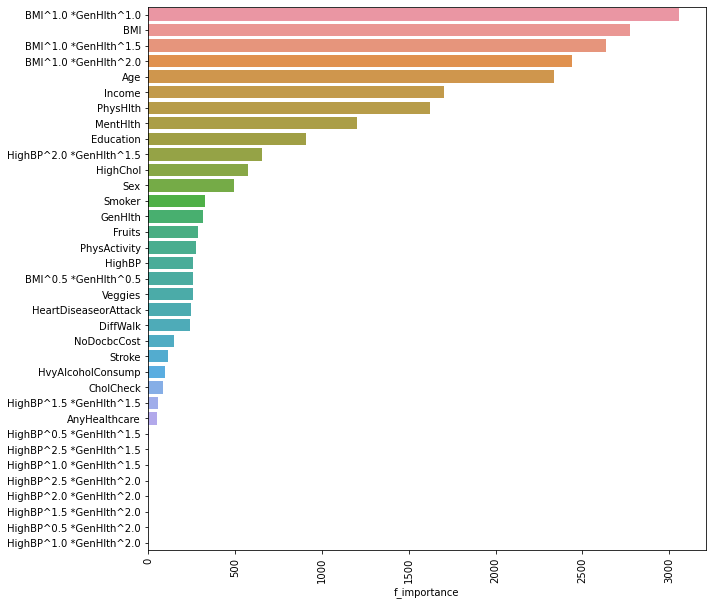

In [129]:
plt.figure(figsize = (10,10))
sns.barplot(feature_importances.f_importance,  feature_importances.index, orient = 'h')
plt.xticks(rotation = 90)
plt.show()

#### RF hyperparameter search w/ RandomizedSearchCV

In [9]:
from sklearn.model_selection import RandomizedSearchCV


In [10]:
# On the original features
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 20)

In [11]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [12]:
n_estimators = np.arange(200, 2000, 50)
max_depth = np.append(np.arange(2,34,2), None)
min_samples_split = np.arange(2, 12,2)
min_samples_leaf = [1, 2, 4, 6, 8]
bootstrap = [True, False]
max_features = ['auto', 'sqrt', 'log2']
criterion = ['gini', 'entropy']

In [13]:
param_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'max_features':max_features,
    'criterion':criterion

}

In [14]:
param_grid

{'n_estimators': array([ 200,  250,  300,  350,  400,  450,  500,  550,  600,  650,  700,
         750,  800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250,
        1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800,
        1850, 1900, 1950]),
 'max_depth': array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, None],
       dtype=object),
 'min_samples_split': array([ 2,  4,  6,  8, 10]),
 'min_samples_leaf': [1, 2, 4, 6, 8],
 'bootstrap': [True, False],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['gini', 'entropy']}

In [15]:
rf_model = RandomForestClassifier(n_jobs=-1)
search = RandomizedSearchCV(estimator=rf_model, n_iter=10, 
            param_distributions = param_grid,
            cv = 5, verbose = 1, scoring = 'accuracy', 
            random_state = 25, n_jobs= -1)

search.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, None],
      dtype=object),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 200,  250,  300,  350,  400,  450,  500,  550,  600,  650,  700,
        750,  800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250,
       1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800,
       1850, 1900, 1950])},
                   r

In [16]:
search.best_params_

{'n_estimators': 450,
 'min_samples_split': 2,
 'min_samples_leaf': 6,
 'max_features': 'log2',
 'max_depth': 16,
 'criterion': 'gini',
 'bootstrap': True}

In [22]:
rf_model = RandomForestClassifier(search.best_params_)

with mlflow.start_run(run_name = "RF, no ad. features hyperparam 4", experiment_id = 1) as run:
    rf = RandomForestClassifier(**search.best_params_)
    rf.fit(X_train, Y_train)
    Y_preds = rf.predict(X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.58      0.15      0.23      7056

    accuracy                           0.85     50736
   macro avg       0.48      0.38      0.38     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.2829746136865342
MSE: 	0.5476781772311574
ACC: 	0.8493771680857773
MCC: 	0.2318908801036315


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [28]:
X, Y = new_data.drop("Diabetes_012", axis = 1), data['Diabetes_012']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 20)

In [29]:
rf_model = RandomForestClassifier(search.best_params_)

with mlflow.start_run(run_name = "RF, ad. features hyperparams 4", experiment_id = 1) as run:
    rf = RandomForestClassifier(**search.best_params_)
    rf.fit(X_train, Y_train)
    Y_preds = rf.predict(X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.15      0.24      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.38      0.38     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.284787921791233
MSE: 	0.551304793440555
ACC: 	0.848470514033428
MCC: 	0.23054306116023987


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

#### XGB hyperparam tuning

In [42]:
with mlflow.start_run(run_name = "XGB KFold baseline, ad. features", experiment_id = 1) as run:
    xgb_baseline = xgboost.XGBClassifier(objective = 'multi:softmax')
    scores = cross_validate(xgb_baseline, X_train, Y_train, cv = 5, scoring = 'accuracy')
    

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:56:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:01:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:01:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:02:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:02:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
np.mean(scores['test_score'])

0.8492835452626479

In [75]:
params = [ np.arange(100, 5000, step=100),
 np.linspace(1e-4, 0.3, 20),
  np.linspace(3, 12, 1),
   np.arange(0.4, 0.9, 0.1),
    [0.1], [99], ["auto", "sqrt", "log2"], [50], [0, .5, 2]]

In [81]:
param_grid = {
        "n_estimators": np.arange(100, 5000, step=100),
        "learning_rate": np.linspace(1e-4, 0.3, 20),
        "max_depth": np.linspace(2, 12, 6).astype(int),
        "subsample": np.arange(0.4, 0.9, 0.1),
        "validation_fraction": [0.05],
        'random_state': [99],
        "gamma":[0, .5, 2]
       
    }

In [82]:
param_grid

{'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
        1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
        2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300,
        3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400,
        4500, 4600, 4700, 4800, 4900]),
 'learning_rate': array([1.00000000e-04, 1.58842105e-02, 3.16684211e-02, 4.74526316e-02,
        6.32368421e-02, 7.90210526e-02, 9.48052632e-02, 1.10589474e-01,
        1.26373684e-01, 1.42157895e-01, 1.57942105e-01, 1.73726316e-01,
        1.89510526e-01, 2.05294737e-01, 2.21078947e-01, 2.36863158e-01,
        2.52647368e-01, 2.68431579e-01, 2.84215789e-01, 3.00000000e-01]),
 'max_depth': array([ 2,  4,  6,  8, 10, 12]),
 'subsample': array([0.4, 0.5, 0.6, 0.7, 0.8]),
 'validation_fraction': [0.05],
 'random_state': [99],
 'max_features': ['auto', 'sqrt', 'log2'],
 'n_iter_no_change': [50],
 'gamma': [0, 0.5, 2]}

In [83]:
xgb_model = xgboost.XGBClassifier(objective = 'multi:softmax')
search = RandomizedSearchCV(estimator=xgb_model, n_iter=10, 
            param_distributions = param_grid,
            cv = 5, verbose = 2, scoring = 'accuracy', 
            random_state = 25, n_jobs= -1)

search.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/slavoj/mambaforge/envs/exper

[03:35:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "max_features", "n_iter_no_change", "validation_fraction" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:35:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "max_features", "n_iter_no_change", "validation_fraction" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:35:27] WARNING: /home/conda/feedstock_

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/slavoj/mambaforge/envs/exper

[03:35:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "max_features", "n_iter_no_change", "validation_fraction" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:35:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "max_features", "n_iter_no_change", "validation_fraction" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:35:28] WARNING: /home/conda/feedstock_